* [Andrej Karpathy: Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4&ab_channel=AndrejKarpathy)

In [1]:
with open("../data/names.txt", "r") as f:
    words = f.read().splitlines()
print(words[:8])
print(len(words))

chars = ["."] + sorted(list(set("".join(words))))
print(chars)
n_chars = len(chars)
print(n_chars)

ctoi = {c:i for i,c in enumerate(chars)}
print(ctoi)
itoc = {i:c for c,i in ctoi.items()}
print(itoc)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033
['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27
{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [2]:
import torch
import random

block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [ctoi["."]] * block_size
        for c in w + ".":
            X.append(context)
            idx = ctoi[c]
            Y.append(idx)
            # print(f"{''.join([itoc[i] for i in context])} -> {c}")
            context = context[1:] + [idx]


    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(X.shape, Y.shape)
    return X, Y

# Splits: train (0.8), val/dev (0.1), test (0.1).
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


[PyTorch internals: ezyang](http://blog.ezyang.com/2019/05/pytorch-internals/)

In [3]:
g = torch.Generator().manual_seed(2147483647)

# Indexing into embedding table is the same as 1-hot encoding and matmul w/ embedding.
emb_dim = 10
C = torch.randn((n_chars, emb_dim), generator=g)

hidden_dim = 200
W1 = torch.randn((block_size * emb_dim, hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)

W2 = torch.randn((hidden_dim, n_chars), generator=g)
b2 = torch.randn(n_chars, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

n_params = sum(p.numel() for p in parameters)
print(f"{n_params=}")

n_params=11897


In [4]:
import torch.nn.functional as F

log_losses = []
for i in range(300_000):
    # Create minibatch.
    inds = torch.randint(0, X_train.shape[0], (32,), generator=g)
    xb, yb = X_train[inds], Y_train[inds]

    # Forward.
    emb = C[xb]
    concat_emb = emb.view(emb.shape[0], -1)
    h = ((concat_emb @ W1) + b1).tanh()

    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, yb)
    log_losses.append(loss.log10().item())

    # Backward.
    for p in parameters:
        p.grad = None
    loss.backward()

    # Determine by increasing lr every step until training starts to diverges.
    # Decay learning rate on plateu (or lr scheduler).
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

print(f"Final minibatch train loss: {loss.item()}")

Final minibatch train loss: 1.8843470811843872


Train loss: 2.118145704269409
Val loss: 2.159245014190674


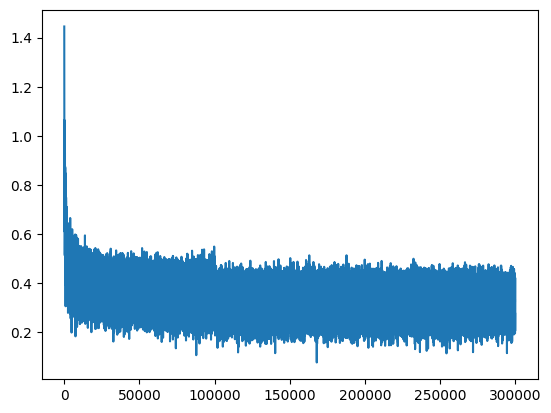

In [5]:
import matplotlib.pyplot as plt

def eval_loss(X, Y):
    with torch.no_grad():
        emb = C[X]
        concat_emb = emb.view(emb.shape[0], -1)
        h = ((concat_emb @ W1) + b1).tanh()

        logits = (h @ W2) + b2
        loss = F.cross_entropy(logits, Y)
    return loss.item()

print(f"Train loss: {eval_loss(X_train, Y_train)}")
print(f"Val loss: {eval_loss(X_val, Y_val)}")

plt.plot(log_losses);

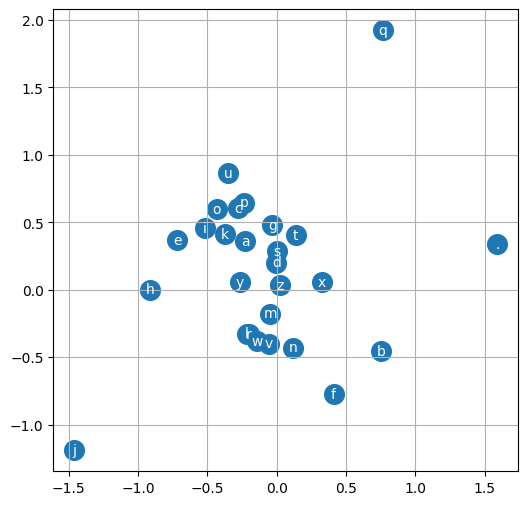

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(C[:, 0].detach().numpy(), C[:, 1].detach().numpy(), s=200)
for i in range(C.shape[0]):
    ax.text(C[i, 0].item(), C[i, 1].item(), itoc[i], ha="center", va="center", color="white")

ax.grid("minor");

In [7]:
for i in range(20):
    new_word = []
    context = [ctoi["."]] * block_size

    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, emb_dim).
        h = ((emb.view(emb.shape[0], -1) @ W1) + b1).tanh()  # (1, hidden_dim).
        logits = (h @ W2) + b2  # (1, hidden_dim)
        probs = logits.softmax(dim=-1)  # (1, hidden_dim)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        new_word.append(itoc[idx])
        context = context[1:] + [idx]

        if idx == 0:
            break

    print("".join(new_word))

dak.
andwon.
dar.
enlondriannaf.
dassentarie.
dabric.
sha.
kashlie.
kynzlynne.
ade.
larke.
briella.
azal.
jalbayleiyah.
eleighaod.
nequintel.
cash.
akdyn.
praydyn.
mayal.
